In [ ]:
import numpy as np
import pandas as pd 
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline      
from sklearn.model_selection import GridSearchCV   
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler

In [ ]:
def convert_to_binary(val):
    if val >= 1:
        return 1
    else:
        return 0

In [ ]:
def plot_distribution(df):
    num_cols = 4 # Number of columns in each row of subplots
    num_rows = (len(df.columns) - 1) // num_cols + 1  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 3*num_rows))
    
    fig.suptitle('Distribution of Binary Values (0s and 1s) \n  Number of estimators : %i ' %df.shape[1], fontsize = 20)

    for i, col in enumerate(df.columns):
        ax = axes[i // num_cols, i % num_cols]
        df[col].value_counts().plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.set_xticklabels(['0', '1'], rotation=0)

    # Hide empty subplots if any
    for i in range(len(df.columns), num_rows * num_cols):
        axes.flatten()[i].axis('off')
    plt.tight_layout(rect=[0, 0.01, 1, 0.95])
    plt.savefig("Binary_distribution.png")
    plt.show()
    return 

In [ ]:
def remove_cols_df(df):
    # Threshold for the percentage
    threshold = 0.99
     # List to hold columns that meet the condition
    columns_to_drop = []

    # Loop through each column
    zero_one_cols_b = df.columns[((df == 0).all()) | ((df == 1).all())]
    columns_to_drop.extend(zero_one_cols_b)
    for column in df.columns:
        # Get the highest count of a single value in this column
        max_count = df[column].value_counts().max()

        # Calculate the percentage of this count relative to the total number of rows
        percent = max_count / len(df)

        # Check if this percentage is greater than or equal to the threshold
        if percent >= threshold:
            # Add the column name to the list
            columns_to_drop.append(column)
    
    df = df.drop(columns_to_drop, axis=1)
    return df 


In [ ]:
def get_column_number(df, column_name):
    try:
        column_number = df.columns.get_loc(column_name) + 1  # Adding 1 to make it 1-indexed
        return column_number
    except KeyError:
        return None  # Return None if column not found

# Load Data

In [ ]:

df_demands = pd.read_csv("demand_scenarios.csv") 

df_demands_lag = df_demands.shift(-1) # Lag data to try add some time involvement
df_demands_fut = df_demands.shift(1) # Consider future data as well as a forecast

#Add dataframe together 

df_X = pd.concat([df_demands,df_demands_lag,df_demands_fut],axis = 1 ).fillna(0) # Concat and replace nan values with 0

#Y targets 

Opt_b_df = pd.read_csv("Opt_b.csv")#Binary
Opt_f_df = pd.read_csv("Opt_f.csv") #Binary

#Rename columns 



tolerance = 0.98
for col in Opt_b_df.columns:
    Opt_b_df[col] = np.where(Opt_b_df[col] >= tolerance, 1, 0) # Tolereance being quite lenient to make sure all are within 
for col in Opt_f_df.columns:
    Opt_f_df[col] = np.where(Opt_f_df[col] >= tolerance, 1, 0)


Opt_b_df = remove_cols_df(Opt_b_df)
Opt_f_df = remove_cols_df(Opt_f_df)

OG_name_b = Opt_b_df.columns
OG_name_f = Opt_f_df.columns

# Create a mapping dictionary for renaming columns
mapping_b = {col: f"b_{col}" for col in Opt_b_df.columns}
mapping_f = {col: f"f_{col}" for col in Opt_f_df.columns}

# Rename the columns using the mapping dictionary
Opt_b_df = Opt_b_df.rename(columns=mapping_b)
Opt_f_df = Opt_f_df.rename(columns=mapping_f)


#Get amount B classifers we are gonna train
num_b = Opt_b_df.shape[1]
#Same for flow lines
num_f = Opt_f_df.shape[1]

# Remove columns with all zeros

targets_combined = pd.concat([Opt_b_df,Opt_f_df],axis = 1)

#Count how many zeros and ones in target 

count_zeros = (targets_combined == 0).sum().sum()
count_ones = (targets_combined == 1).sum().sum()


#pick columns (targets with most 1, and one with almost no ones)

target_names = targets_combined.columns # For output of models 

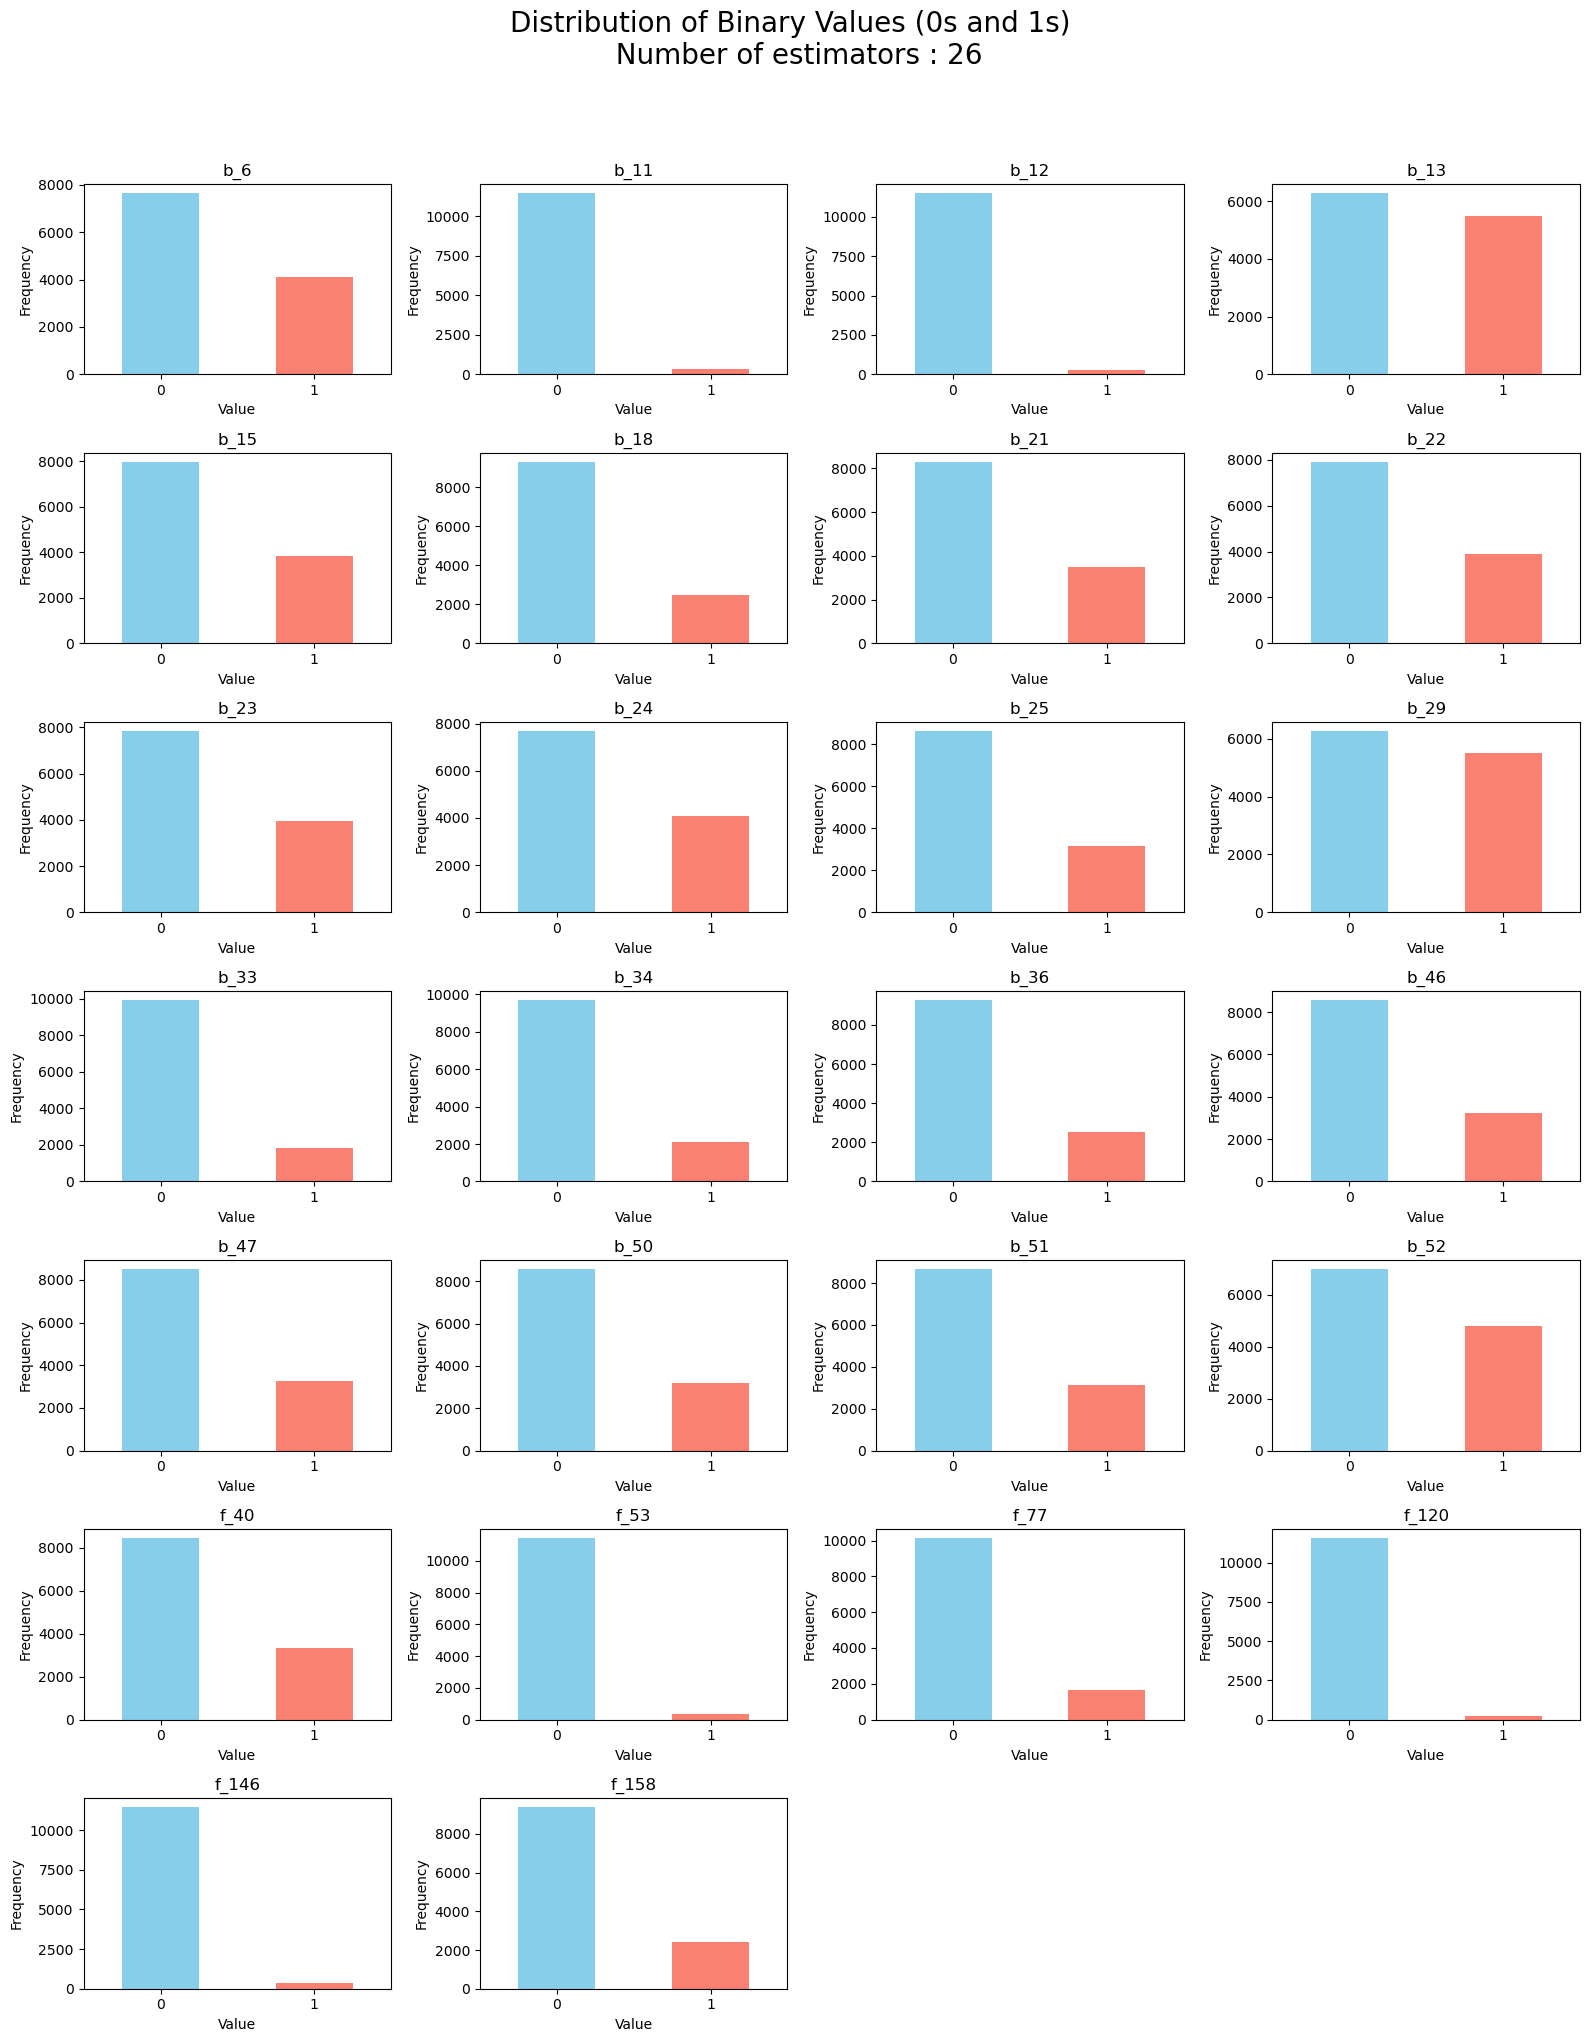

In [ ]:
plot_distribution(targets_combined)

In [ ]:
#Training data for our set 
#We don't shuffle the data set to begin with because the constraints connected through time 
#So we want to main scenarios for our prediction in the PS in gurobi
X_train, X_test, y_train, y_test = train_test_split(df_X, targets_combined, test_size=0.20, random_state=42, shuffle = False)
#We howver shuffle training data 
X_train = X_train.sample(frac=1, random_state = 42)
y_train = y_train.sample(frac=1,random_state = 42)

#Standard scale our training data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# SVC

## Grid Search for best parameters 

In [ ]:
"""
parameters_svc = {"estimator__kernel" : ["linear","poly"],
                    "estimator__C" : [ 0.01, 0.1, 1, 10,  ] }

clf_svc = OneVsRestClassifier(SVC(),n_jobs=8)
clf_svc_grid = GridSearchCV(clf_svc, parameters_svc, cv=3, return_train_score=False,n_jobs=8).fit(X_train, y_train) 

print (clf_svc_grid.best_score_) # Best Score = 0.26413392489643694
print (clf_svc_grid.best_params_) # Best parameters = {'estimator__C': 0.01, 'estimator__kernel': 'linear'}
"""

'\nparameters_svc = {"estimator__kernel" : ["linear","poly"],\n                    "estimator__C" : [ 0.01, 0.1, 1, 10,  ] }\n\nclf_svc = OneVsRestClassifier(SVC(),n_jobs=8)\nclf_svc_grid = GridSearchCV(clf_svc, parameters_svc, cv=3, return_train_score=False,n_jobs=8).fit(X_train, y_train) \n\nprint (clf_svc_grid.best_score_) # Best Score = 0.26413392489643694\nprint (clf_svc_grid.best_params_) # Best parameters = {\'estimator__C\': 0.01, \'estimator__kernel\': \'linear\'}\n'

Best Score : 0.26413392489643694

Best Parameters: {'estimator__C': 0.01, 'estimator__kernel': 'linear'}

## SVC with best parameters

In [ ]:
#Write best params 
best_params = {'C': 0.01, 'kernel': 'linear'}

clf_svc = OneVsRestClassifier(SVC(**best_params),n_jobs=8).fit(X_train,y_train) # still need to do cross val to find the best weights 
y_pred_svc = clf_svc.predict(X_test)
svc_report = classification_report(y_test, y_pred_svc, target_names=target_names, output_dict = True, zero_division = np.nan)
svc_results_df =  pd.DataFrame(svc_report).transpose()
svc_results_df.to_csv("SVC_results.csv")


#Run time : 1 min 54 s

{'b_6': {'precision': 0.7584269662921348, 'recall': 0.8074162679425837, 'f1-score': 0.7821552723059096, 'support': 836.0}, 'b_11': {'precision': 1.0, 'recall': 0.11428571428571428, 'f1-score': 0.20512820512820512, 'support': 70.0}, 'b_12': {'precision': 1.0, 'recall': 0.03278688524590164, 'f1-score': 0.06349206349206349, 'support': 61.0}, 'b_13': {'precision': 0.9165402124430956, 'recall': 0.9556962025316456, 'f1-score': 0.935708752904725, 'support': 1264.0}, 'b_15': {'precision': 0.6858513189448441, 'recall': 0.7803547066848567, 'f1-score': 0.7300574345883856, 'support': 733.0}, 'b_18': {'precision': 0.6247086247086248, 'recall': 0.5095057034220533, 'f1-score': 0.5612565445026179, 'support': 526.0}, 'b_21': {'precision': 0.6957746478873239, 'recall': 0.6957746478873239, 'f1-score': 0.6957746478873239, 'support': 710.0}, 'b_22': {'precision': 0.7609223300970874, 'recall': 0.7847309136420526, 'f1-score': 0.7726432532347505, 'support': 799.0}, 'b_23': {'precision': 0.9730250481695568, 'r

In [ ]:
#Save Prediction data and which generator/line information 

# Convert the predictions to a DataFrame
df_SVC_b = pd.DataFrame(y_pred_svc[:,:num_b], columns= OG_name_b)
df_SVC_f = pd.DataFrame(y_pred_svc[:,num_b:], columns= OG_name_f)

#to latex file 

#Save the information to a CSV file
df_SVC_b.to_csv('SVC_predictions_b.csv', index=False)
df_SVC_f.to_csv('SVC_predictions_f.csv', index=False)
# Make it into a latex table 
svc_results_df_copy = svc_results_df.copy()

svc_results_df_copy.index = ['$' + index.replace('_', '_{') + '}$' for index in svc_results_df_copy.index]

# Format precision, recall, and f1-score to 3 digits
svc_results_df_copy[['precision', 'recall', 'f1-score']] = svc_results_df_copy[['precision', 'recall', 'f1-score']].map(lambda x: f'{x:.3f}' if not pd.isnull(x) else 'NaN')

# Convert DataFrame to LaTeX table
latex_table = svc_results_df_copy.to_latex("SVC_latex.tex",escape=False, label = "Appendix Log Results",position = "h", bold_rows= True,)



## Grid Search for Logistic Regression 

In [ ]:
"""
#parameters for logistic grid search 
params_log = {
     'estimator__C' : [ 0.01, 0.1, 1, 10, ],
    'estimator__solver': ['liblinear','lbfgs'],
    'estimator__fit_intercept': [True,False]
}

#clf_log =  LogisticRegression(multi_class= "ovr",max_iter = 200).fit(X_train, y_train) # This works if we categorize all the different
# labels as 1,2,3,4,5,6,7... etc and then it fits a binary classifer for each

clf_log = OneVsRestClassifier(LogisticRegression(),n_jobs=8)
log_grid = GridSearchCV (clf_log, params_log, cv=3, return_train_score=False,n_jobs=8).fit(X_train, y_train) 

print (log_grid.best_score_) # Best Score = 0.2669980724310383
print (log_grid.best_params_) # Best parameters = {'estimator__C': 0.1, 'estimator__fit_intercept': True, 'estimator__solver': 'liblinear'}
"""

'\n#parameters for logistic grid search \nparams_log = {\n     \'estimator__C\' : [ 0.01, 0.1, 1, 10, ],\n    \'estimator__solver\': [\'liblinear\',\'lbfgs\'],\n    \'estimator__fit_intercept\': [True,False]\n}\n\n#clf_log =  LogisticRegression(multi_class= "ovr",max_iter = 200).fit(X_train, y_train) # This works if we categorize all the different\n# labels as 1,2,3,4,5,6,7... etc and then it fits a binary classifer for each\n\nclf_log = OneVsRestClassifier(LogisticRegression(),n_jobs=8)\nlog_grid = GridSearchCV (clf_log, params_log, cv=3, return_train_score=False,n_jobs=8).fit(X_train, y_train) \n\nprint (log_grid.best_score_) # Best Score = 0.2669980724310383\nprint (log_grid.best_params_) # Best parameters = {\'estimator__C\': 0.1, \'estimator__fit_intercept\': True, \'estimator__solver\': \'liblinear\'}\n'

## Best Params for Logistic 

Best Score : 0.2669980724310383

Best Parameters : {'estimator__C': 0.1, 'estimator__fit_intercept': True, 'estimator__solver': 'liblinear'}

In [ ]:
#make as a function to run this or not 

best_params_log = {'C': 0.1, 'fit_intercept': True, 'solver': 'liblinear'}
clf_log =  OneVsRestClassifier(LogisticRegression(**best_params_log),n_jobs=8) .fit(X_train,y_train)# 

y_pred_log = clf_log.predict(X_test)
log_report = classification_report(y_test, y_pred_log, target_names=target_names, output_dict = True, zero_division = np.nan)
log_results_df =  pd.DataFrame(log_report).transpose()
log_results_df.to_csv("Log_results.csv")
#Computation time 6.3 S

{'b_6': {'precision': 0.7572706935123042, 'recall': 0.8098086124401914, 'f1-score': 0.7826589595375723, 'support': 836.0}, 'b_11': {'precision': 0.7777777777777778, 'recall': 0.2, 'f1-score': 0.3181818181818182, 'support': 70.0}, 'b_12': {'precision': 0.9090909090909091, 'recall': 0.16393442622950818, 'f1-score': 0.27777777777777773, 'support': 61.0}, 'b_13': {'precision': 0.918133129303749, 'recall': 0.9493670886075949, 'f1-score': 0.9334889148191365, 'support': 1264.0}, 'b_15': {'precision': 0.6812278630460449, 'recall': 0.7871759890859482, 'f1-score': 0.730379746835443, 'support': 733.0}, 'b_18': {'precision': 0.621867881548975, 'recall': 0.5190114068441065, 'f1-score': 0.5658031088082903, 'support': 526.0}, 'b_21': {'precision': 0.6986111111111111, 'recall': 0.7084507042253522, 'f1-score': 0.7034965034965034, 'support': 710.0}, 'b_22': {'precision': 0.7542787286063569, 'recall': 0.772215269086358, 'f1-score': 0.7631416202844773, 'support': 799.0}, 'b_23': {'precision': 0.9705505761

In [ ]:

# Convert the predictions to a DataFrame
df_Log_b = pd.DataFrame(y_pred_log[:,:num_b], columns= OG_name_b)
df_Log_f = pd.DataFrame(y_pred_log[:,num_b:], columns= OG_name_f)



#Save the information to a CSV file
df_Log_b.to_csv('Log_predictions_b.csv', index=False)
df_Log_f.to_csv('Log_predictions_f.csv', index=False)


log_results_df_copy = log_results_df.copy()

log_results_df_copy.index = ['$' + index.replace('_', '_{') + '}$' for index in log_results_df_copy.index]

# Format precision, recall, and f1-score to 3 digits
log_results_df_copy[['precision', 'recall', 'f1-score']] = log_results_df_copy[['precision', 'recall', 'f1-score']].map(lambda x: f'{x:.3f}' if not pd.isnull(x) else 'NaN')

# Convert DataFrame to LaTeX table
latex_table = log_results_df_copy.to_latex("Log_latex.tex",escape=False, label = "Appendix Log Results",position = "h", bold_rows= True,)

print(latex_table)

None


In [ ]:

"""
clf_tree = MultiOutputClassifier(RandomForestClassifier(),n_jobs=8)
#Remove comment when done ( this takes awhile to do , can proabably be less involved tbf)
params_tree = {
    'estimator__n_estimators': [i for i in range(50, 300, 75)],
    'estimator__max_depth': [ 30,50,70 ,None],
    'estimator__max_features': ['auto', 'sqrt', 'log2']}
    
clf_tree_grid = GridSearchCV (clf_tree, params_tree, cv=3, return_train_score=False,n_jobs=8).fit(X_train, y_train)

print(clf_tree_grid.best_score_) # Best Score = 0.21799040961363625
print(clf_tree_grid.best_params_) # Best parameters = {'estimator__max_depth': 30, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 200}
"""


"\nclf_tree = MultiOutputClassifier(RandomForestClassifier(),n_jobs=8)\n#Remove comment when done ( this takes awhile to do , can proabably be less involved tbf)\nparams_tree = {\n    'estimator__n_estimators': [i for i in range(50, 300, 75)],\n    'estimator__max_depth': [ 30,50,70 ,None],\n    'estimator__max_features': ['auto', 'sqrt', 'log2']}\n    \nclf_tree_grid = GridSearchCV (clf_tree, params_tree, cv=3, return_train_score=False,n_jobs=8).fit(X_train, y_train)\n\nprint(clf_tree_grid.best_score_) # Best Score = 0.21799040961363625\nprint(clf_tree_grid.best_params_) # Best parameters = {'estimator__max_depth': 30, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 200}\n"

Best Score = 0.21576269805377846

Best Parameters = {'estimator__max_depth': 30, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 200}

# Random Forrest classifier with optimal parameters

In [ ]:
best_params_tree = {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200}

#Will have some NaN values due to randomness of the sampling 

clf_tree = MultiOutputClassifier(RandomForestClassifier(**best_params_tree, random_state= 420),n_jobs=8).fit(X_train,y_train)

y_pred_tree = clf_tree.predict(X_test)
tree_report = classification_report(y_test, y_pred_tree, target_names=target_names, output_dict = True,zero_division = np.nan)
tree_results_df =  pd.DataFrame(tree_report).transpose()
tree_results_df.to_csv("Tree_results.csv")
# Computation time 5 min 26 sec

In [ ]:
# Convert the predictions to a DataFrame
df_Tree_b = pd.DataFrame(y_pred_tree[:,:num_b], columns= OG_name_b)
df_Tree_f = pd.DataFrame(y_pred_tree[:,num_b:], columns= OG_name_f)

#to latex file 
tree_results_df.to_latex("Tree_latex.tex", index=True,
                  float_format="{:.4}".format,)

#Save the information to a CSV file
df_Tree_b.to_csv('Tree_predictions_b.csv', index=False)
df_Tree_f.to_csv('Tree_predictions_f.csv', index=False)

In [ ]:
#To latex
tree_results_df_copy = tree_results_df.copy()

tree_results_df_copy.index = ['$' + index.replace('_', '_{') + '}$' for index in tree_results_df_copy.index]

# Format precision, recall, and f1-score to 3 digits
tree_results_df_copy[['precision', 'recall', 'f1-score']] = tree_results_df_copy[['precision', 'recall', 'f1-score']].map(lambda x: f'{x:.3f}' if not pd.isnull(x) else 'NaN')

# Convert DataFrame to LaTeX table
latex_table = tree_results_df_copy.to_latex("Tree_latex.tex",escape=False, label = "Appendix Log Results",position = "h", bold_rows= True,)

print(latex_table)

print(latex_table)

None
None


## Compare ROC curves for some different target variables 

In [ ]:
def plot_ROC(estimators,target_names ):

    num_cols = 4  # Number of columns in each row of subplots
    num_rows = (len(estimators) - 1) // num_cols + 1  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    fig.suptitle('ROC Curve Comparison \n  Number of estimators : %i ' %len(estimators), fontsize = 20)

    for i, estimator in enumerate(estimators):
        ax = axes[i // num_cols, i % num_cols]

        # Display ROC curve for each estimator on its own subplot
        RocCurveDisplay.from_estimator(clf_svc.estimators_[estimator], X_test, y_test.values[:, estimator], ax=ax)
        RocCurveDisplay.from_estimator(clf_log.estimators_[estimator], X_test, y_test.values[:, estimator], ax=ax)
        RocCurveDisplay.from_estimator(clf_tree.estimators_[estimator], X_test, y_test.values[:, estimator], ax=ax)
    
        # You might want to set individual titles for each subplot
        ax.set_title(f'Estimator {target_names[i]}')

        ax.legend(fontsize='small', loc='lower right', columnspacing=1, handlelength=2)

    # Hide empty subplots if any
    for i in range(len(estimators), num_rows * num_cols):
        axes.flatten()[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for the main title
    plt.savefig("AUC_plots_all.png")
    plt.show()
  
    return 

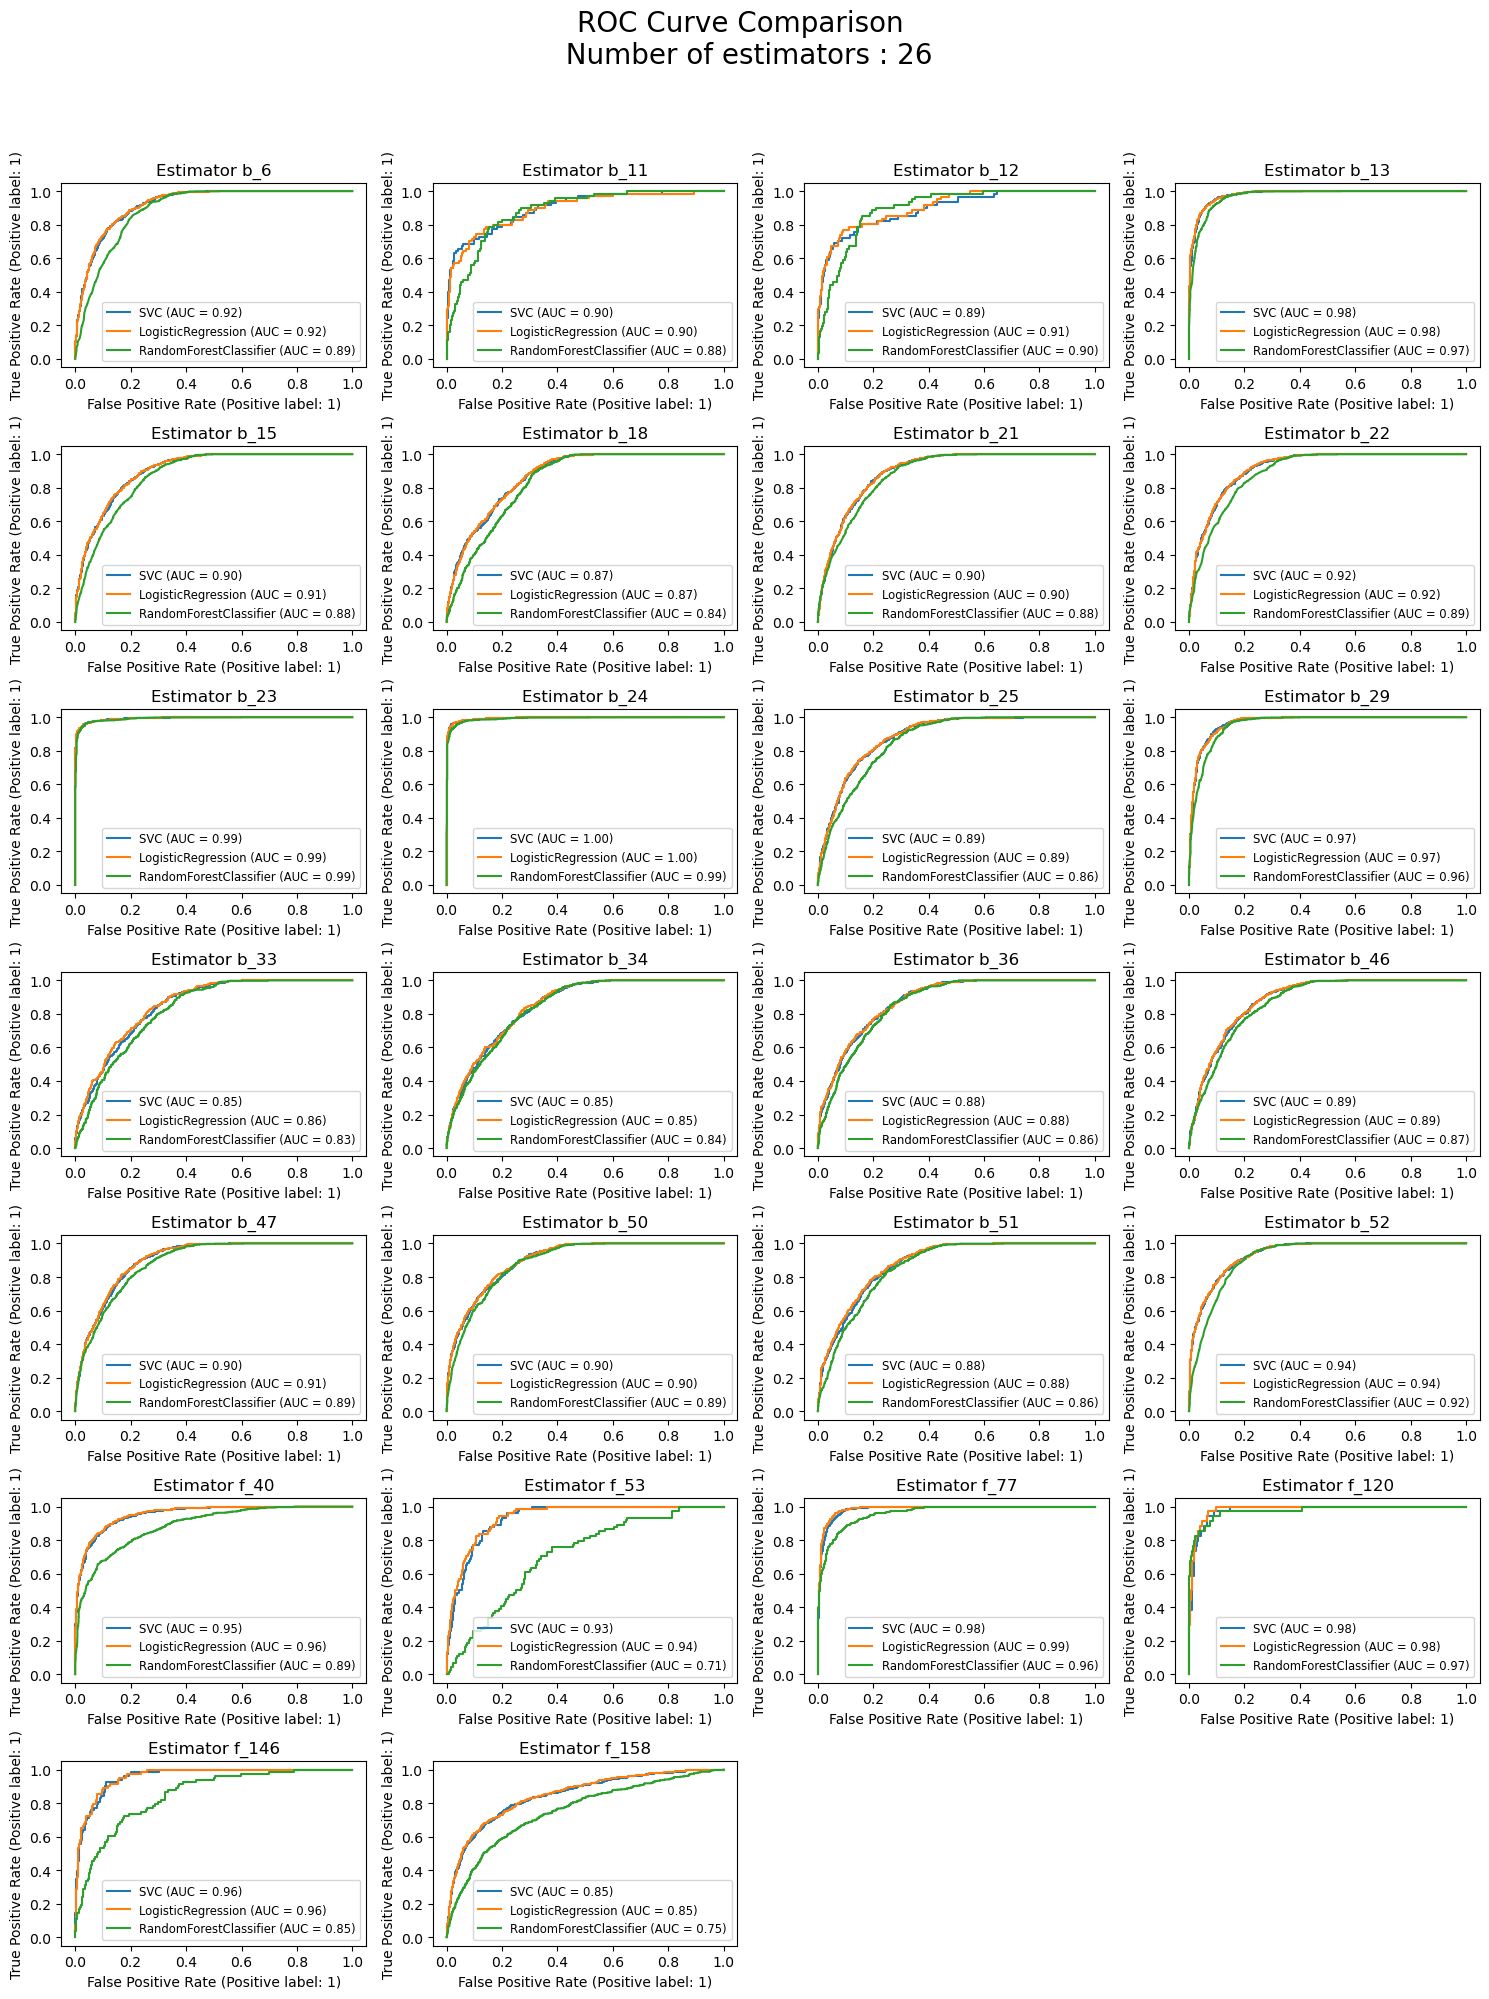

In [ ]:
plot_ROC(np.arange(targets_combined.shape[1]),target_names)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d433c74-094f-4b64-b183-e04fb92f095e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>